<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week18_deeplearning_cv/ch18_6_image_search_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch 6. image search part 1.

이번 챕터와 다음 챕터에서는 딥러닝 모델을 이용한 신발 이미지 검색 서비스를 만들어보겠습니다. 만들고자 하는 서비스의 구조는 아래와 같습니다.

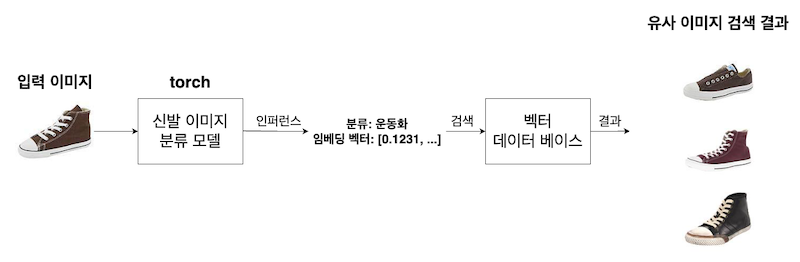

이미지 검색은 크게 3가지 단계로 이루어집니다.

1. 이미지 분류
미리 신발 이미지에 대해서 fine-tuning한 모델을 이용해 신발 이미지의 클래스를 분류하고, 임베딩 벡터를 얻습니다.

2. 이미지 유사도 검색
미리 데이터 셋의 신발 이미지들의 임베딩 벡터를 추출하여 벡터 데이터 베이스에 저장해놓습니다. 이제 모델을 통해 추론한 클래스와 임베딩 벡터를 가지고 유사도 검색을 진행한 다음, top 개의 결과를 리턴해주면 됩니다.

이를 구현하기 위해선 다시 2가지 사전 작업이 필요합니다.

1. 신발 이미지 분류 모델 만들기
먼저 신발 이미지의 종류를 구분하고, 임베딩 벡터를 추출하는 모델이 필요합니다. 이는 이미지넷 pre-trained resnet-18 모델을 fine-tuning하여 사용하겠습니다.

2. 임베딩 벡터 추출하여 벡터 데이터 베이스에 저장하기
fine-tuning한 모델로 train과 val 데이터 셋 이미지들의 임베딩 벡터를 모두 추출한 다음, 벡터 데이터 베이스에 저장하겠습니다. 벡터 데이터 베이스는 pinecone이라는 서비스를 사용하겠습니다.

이번 챕터에서는 사전 작업 중 1단계인 fine-tuning 단계를 수행해보겠습니다.

## 데이터 셋 준비

In [ ]:
!unzip "./drive/MyDrive/2023 데이터 분석 및 시각화 취업 과정/shoes.zip" -d "/content"

### Dataset, DataLoader 생성

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(f"{img_dir}/label.csv")
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}"
        img = read_image(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.img_labels.iloc[idx, 1]
        return img, label

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()

train_dataset = CustomImageDataset("./shoes/train", transform=transform)
val_dataset = CustomImageDataset("./shoes/val", transform=transform)

### label dict 확인

In [ ]:
import json

with open("./drive/MyDrive/2023 데이터 분석 및 시각화 취업 과정/shoes/label_dict.json") as fr:
    label_dict = json.loads(fr.read())

In [ ]:
label_dict

{'0': 'boat_shoes',
 '1': 'boots_ankle',
 '2': 'boots_knee_high',
 '3': 'boots_mid_calf',
 '4': 'clogs_and_mules',
 '5': 'flats',
 '6': 'heels',
 '7': 'loafers',
 '8': 'oxfords',
 '9': 'sandal',
 '10': 'slipper',
 '11': 'sneakers'}

### label 분포 확인

예측해야할 클래스의 개수는 몇개고, 각 클래스 별 이미지 데이터 개수가 몇개인지 확인해보겠습니다.

<Axes: xlabel='label'>

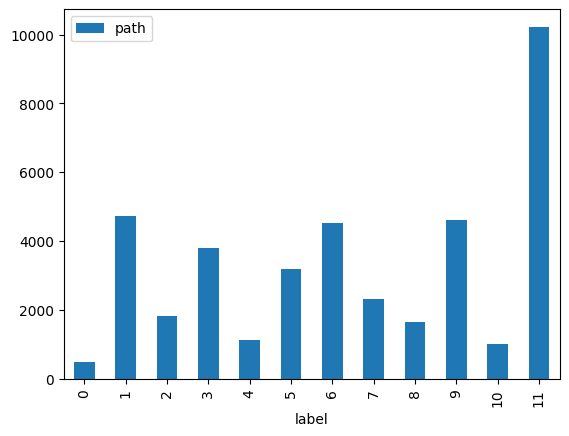

In [ ]:
train_dataset.img_labels.groupby("label").count().plot(kind="bar")

<Axes: xlabel='label'>

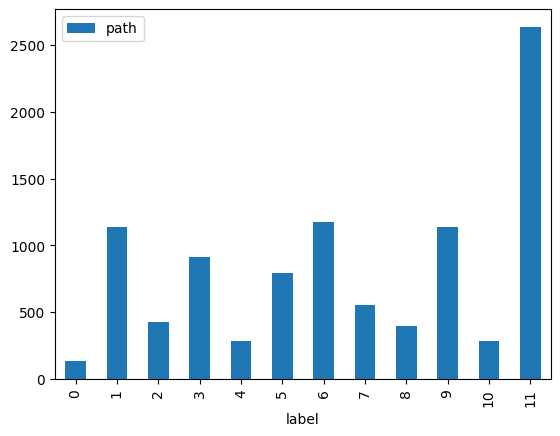

In [ ]:
val_dataset.img_labels.groupby("label").count().plot(kind="bar")

확인 결과 각 클래스 별로 데이터 셋의 개수가 상당히 차이가 난다는 것을 알 수 있습니다. 따라서 단순히 Accuracy 만으로 모델의 성능을 측정하는 것은 무리가 있다고 판단할 수 있습니다.

### Batch 시각화

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, drop_last=True)

In [ ]:
from matplotlib import pyplot as plt

def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0][:8]
    label_batch = batch[1][:8]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[str(label_batch[i].item())]}")

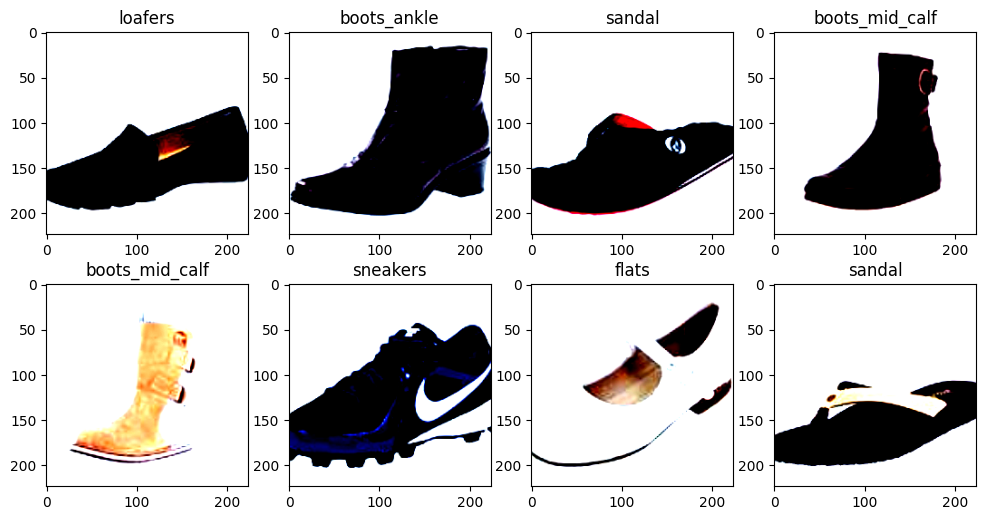

In [ ]:
for batch in train_dataloader:
    plot_batch(batch, label_dict)
    break

## 모델 학습

### 디바이스 셋팅

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 모델 학습 코드

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import f1_score


def train_model(model):
    model.train()
    loss_list = []
    f1_score_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        f1_score_val = f1_score(pred.cpu().numpy(), y_train.cpu().numpy(), average="weighted", zero_division=0)
        f1_score_list.append(f1_score_val)
    return get_mean(loss_list), get_mean(f1_score_list)



In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    f1_score_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            f1_score_val = f1_score(pred.cpu().numpy(), y_val.cpu().numpy(), average="weighted")
            f1_score_list.append(f1_score_val)
    return get_mean(loss_list), get_mean(f1_score_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    savedir = "./drive/MyDrive/dscamp_2023/shoes"
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_f1_score = train_model(model)
        val_loss, val_f1_score = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_f1_score"].append(train_f1_score)
        logs["val_loss"].append(val_loss)
        logs["val_f1_score"].append(val_f1_score)
        print(f"epoch {epoch + 1} train - loss: {train_loss} f1_score: {train_f1_score} "\
              f"val - loss: {val_loss} f1_score: {val_f1_score}")
        torch.save(model.state_dict(), f"{savedir}/resnet18_finetune_{epoch + 1}_{round(val_f1_score, 4)}.pth")
    return logs

In [ ]:
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_f1_score"], label="train")
    ax1.plot(logs["val_f1_score"], label="val")
    ax1.legend()
    ax1.set_title("macro average f1 score")
    plt.legend()

### 모델 생성

pretrained resnet 18을 가져와서 마지막 레이어만 교체해줍니다.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

In [ ]:
# 전체 모델 weight freeze
for param in model.parameters():
    param.requires_grad = False

# 마지막 컨볼루션 레이어 weight True
for param in model.layer4.parameters():
    param.requires_grad = True

# 마지막 레이어는 교체
model.fc = torch.nn.Linear(in_features=512, out_features=12)

### 하이퍼 파라미터 셋팅

In [ ]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

### 모델 학습

100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


epoch 1 train - loss: 0.4605 f1_score: 0.8423 val - loss: 0.384 f1_score: 0.7999


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


epoch 2 train - loss: 0.2729 f1_score: 0.9021 val - loss: 0.4055 f1_score: 0.8012


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


epoch 3 train - loss: 0.177 f1_score: 0.9349 val - loss: 0.4018 f1_score: 0.8124


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


epoch 4 train - loss: 0.1101 f1_score: 0.9592 val - loss: 0.4979 f1_score: 0.7968


100%|██████████| 38/38 [00:43<00:00,  1.14s/it]


epoch 5 train - loss: 0.0704 f1_score: 0.9739 val - loss: 0.4204 f1_score: 0.8284


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


epoch 6 train - loss: 0.0422 f1_score: 0.9848 val - loss: 0.5735 f1_score: 0.8115


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


epoch 7 train - loss: 0.0304 f1_score: 0.9893 val - loss: 0.5175 f1_score: 0.8323


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


epoch 8 train - loss: 0.0254 f1_score: 0.991 val - loss: 0.5929 f1_score: 0.8236


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


epoch 9 train - loss: 0.031 f1_score: 0.9891 val - loss: 0.5374 f1_score: 0.8232


100%|██████████| 38/38 [00:43<00:00,  1.14s/it]


epoch 10 train - loss: 0.027 f1_score: 0.9905 val - loss: 0.5971 f1_score: 0.8215


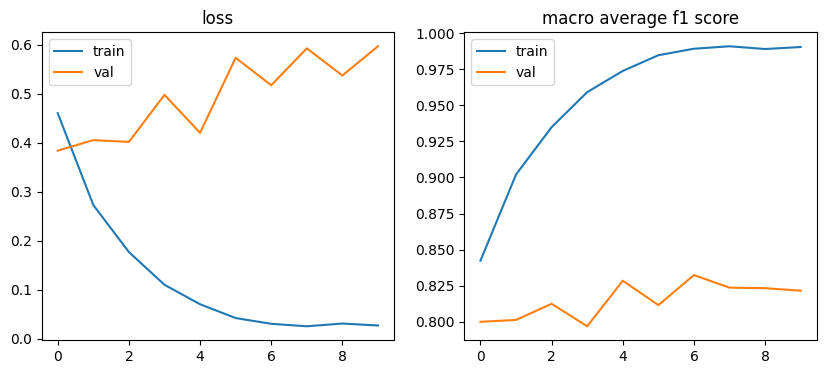

In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
logs = train_validate_model(model)
plot_logs(logs)

## 정리

이번 챕터에서는 이미지 검색에 사용하기 위한 신발 이미지 분류 모델을 만들어보았습니다. 다음 챕터에서는 fine-tuning한 모델을 이용해 이미지로부터 피쳐를 뽑아서 벡터 데이터베이스에 저장해보겠습니다.